In [1]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torchaudio
import torch
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Resizing, Conv2D, Dropout, BatchNormalization, MaxPooling2D, MaxPool2D, Flatten, Dense, Input, LeakyReLU
from tqdm import tqdm
import tensorflow_addons as tfa

F1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

# Configuración de parámetros
class Config:
    def __init__(self, architecture='CNN_LF', epochs=50, sample_rate=None, time=5, n_splits=5, window_size=5):
        self.architecture = architecture
        self.epochs = epochs
        self.sample_rate = sample_rate
        self.time = time
        self.n_splits = n_splits
        self.window_size = window_size

# Funciones de Preprocesamiento
def load_audio_data(directory, window_size, sample_rate):
    audio_dict = {}
    for file_name in os.listdir(directory):
        if file_name.endswith(".wav"):
            waveform, sr = torchaudio.load(os.path.join(directory, file_name))
            if sample_rate is None:
                sample_rate = sr
            num_windows = int(waveform.shape[1] / (window_size * sample_rate))
            for i in range(num_windows):
                start = i * window_size * sample_rate
                end = (i + 1) * window_size * sample_rate
                audio_dict[f"{file_name}_{i}"] = waveform[:, start:end].numpy()
    return audio_dict, sample_rate

def preprocess_audio(audio_dict, sample_rate):
    audio_dict = copy.deepcopy(audio_dict)
    n_mels = 128
    n_fft = int(sample_rate * 0.029)
    hop_length = int(sample_rate * 0.010)
    win_length = int(sample_rate * 0.025)

    for filename, waveform in tqdm(audio_dict.items(), desc='MELSPECTROGRAM'):
        waveform = torch.from_numpy(waveform)
        spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length, win_length=win_length)(waveform)
        spec = torchaudio.transforms.AmplitudeToDB()(spec)
        spec = spec.numpy()
        spec = (spec - spec.min()) / (spec.max() - spec.min())
        audio_dict[filename] = spec
    return audio_dict

def pad_and_crop_spectrograms(spectrograms, target_shape=(128, 128)):
    padded_spectrograms = []
    for spec in spectrograms:
        if spec.shape[0] > target_shape[0]:
            spec = spec[:target_shape[0], :]
        if spec.shape[1] > target_shape[1]:
            spec = spec[:, :target_shape[1]]
        
        pad_width = [(0, max(0, target_shape[0] - spec.shape[0])), 
                     (0, max(0, target_shape[1] - spec.shape[1]))]
        
        padded_spec = np.pad(spec, pad_width, mode='constant')
        padded_spectrograms.append(padded_spec)
    return np.array(padded_spectrograms)

def train_test_split_audio(audio_dict):
    df = pd.read_csv('Dataset.csv', usecols=['Participant_ID', 'PHQ-9 Score'], dtype={1: str})
    df['labels'] = np.zeros([len(df),], dtype=int)
    df.loc[df['PHQ-9 Score'] < 10, 'labels'] = 0
    df.loc[df['PHQ-9 Score'] >= 10, 'labels'] = 1

    labels = df.set_index('Participant_ID').to_dict()['labels']

    X, Y = [], []
    for filename, data in tqdm(audio_dict.items(), 'LABEL'):
        ID = filename[:3]
        if ID in labels:
            dep = 0 if labels[ID] == 0 else 1
            [X.append(x) for x in data]
            [Y.append(dep) for x in data]

    X = pad_and_crop_spectrograms(X)
    Y = np.array(Y)

    X = X[..., np.newaxis]
    return X, Y

# Definición de Modelos
def build_model(config):
    if config.architecture == 'CNN_LF':
        return build_CNN_LF_model()
    elif config.architecture == 'reduced_model':
        return build_reduced_model()
    elif config.architecture == 'Spectro_CNN':
        return build_Spectro_CNN_model()
    else:
        raise ValueError("Arquitectura no soportada")

def build_CNN_LF_model(input_shape=(128, 128, 1)):
    model = Sequential()
    model.add(Resizing(128, 128, input_shape=input_shape))
    model.add(Conv2D(30, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(15, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    return model

def build_reduced_model(input_shape=(128, 128, 1)):
    model = Sequential([
        BatchNormalization(name='batch_normalization_9'),
        Conv2D(16, kernel_size=(3, 3), padding='same', input_shape=input_shape, name='conv2d_6'),
        LeakyReLU(alpha=0.01, name='leaky_re_lu_9'),
        BatchNormalization(name='batch_normalization_10'),
        Conv2D(8, (3, 3), padding='same', name='conv2d_7'),
        LeakyReLU(alpha=0.01, name='leaky_re_lu_10'),
        BatchNormalization(name='batch_normalization_11'),
        Flatten(name='flatten_6'),
        Dense(32, name='dense_6'),
        LeakyReLU(alpha=0.01, name='leaky_re_lu_11'),
        Dense(1, activation='sigmoid', name='dense_7')
    ])
    return model

def build_Spectro_CNN_model(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    for _ in range(31):
        x = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.01)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Plot de Espectrogramas
def plot_spectrogram(spectrogram, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

# Función para calcular la especificidad
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Entrenamiento y Evaluación
def train_and_evaluate_model(model, X_train, Y_train, X_val, Y_val, X_test, Y_test, config):
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy", 'Precision', 'Recall', F1])
    model.fit(X_train, Y_train, epochs=config.epochs, validation_data=(X_val, Y_val))
    results = model.evaluate(X_test, Y_test)
    
    # Predicciones para métricas adicionales
    Y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = results[1]
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    specificity = specificity_score(Y_test, Y_pred)
    
    return results[0], accuracy, precision, recall, f1, specificity

# Ejecución Principal
def main(architecture='CNN_LF', epochs=50, n_splits=5, window_size=10):
    config = Config(architecture=architecture, epochs=epochs, n_splits=n_splits, window_size=window_size)
    directory = './SM-27'
    
    audio_dict, sample_rate = load_audio_data(directory, config.window_size, config.sample_rate)
    audio_dict = preprocess_audio(audio_dict, sample_rate)
    X, Y = train_test_split_audio(audio_dict)

    # División inicial en conjuntos de entrenamiento+validación y prueba
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    # Plot del primer y último espectrograma
    plot_spectrogram(X[0].squeeze(), "Primer Espectrograma")
    plot_spectrogram(X[-1].squeeze(), "Último Espectrograma")
    
    kfold = KFold(n_splits=config.n_splits, shuffle=True)

    results = []
    
    for fold, (train_index, val_index) in enumerate(kfold.split(X_train_val), 1):
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        Y_train, Y_val = Y_train_val[train_index], Y_train_val[val_index]
        
        model = build_model(config)
        fold_results = train_and_evaluate_model(model, X_train, Y_train, X_val, Y_val, X_test, Y_test, config)
        results.append(fold_results)
    
    results = np.array(results)
    avg_results = np.mean(results, axis=0)
    
    print("\nResults per fold:")
    for i, result in enumerate(results, 1):
        print(f"Fold {i} - Loss: {result[0]}, Accuracy: {result[1]}, Precision: {result[2]}, Recall: {result[3]}, F1-score: {result[4]}, Specificity: {result[5]}")
    
    print("\nAverage results:")
    print(f"Loss: {avg_results[0]}, Accuracy: {avg_results[1]}, Precision: {avg_results[2]}, Recall: {avg_results[3]}, F1-score: {avg_results[4]}, Specificity: {avg_results[5]}")
    return avg_results




c:\Users\herna\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\herna\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

In [2]:
#main()

In [3]:
#main(architecture='reduced_model')

In [4]:
#main(architecture='Spectro_CNN')

Running experiment 1/18: CNN_LF_splits_5_epochs_100_window_2


LABEL: 100%|██████████| 15990/15990 [00:00<00:00, 301132.03it/s]


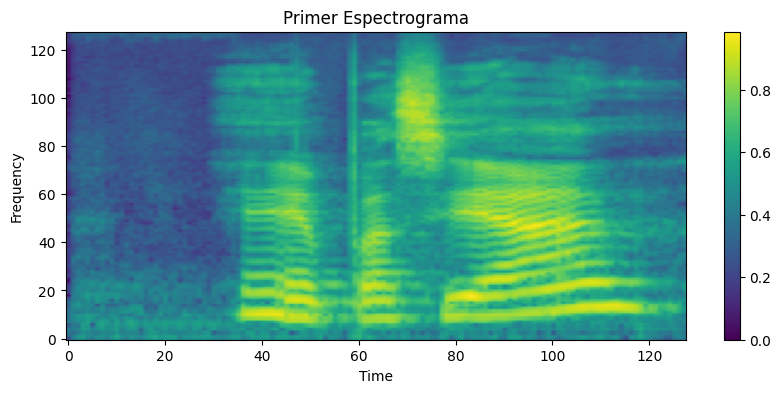

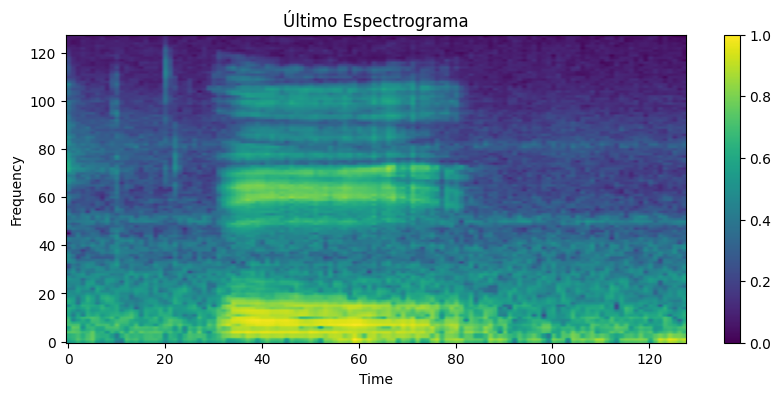

Epoch 1/100
320/320 [==============================] - 14s 23ms/step - loss: 0.9564 - accuracy: 0.5205 - precision: 0.4959 - recall: 0.4848 - f1_score: 0.4903 - val_loss: 0.7031 - val_accuracy: 0.5143 - val_precision: 0.4993 - val_recall: 0.8879 - val_f1_score: 0.6392
Epoch 2/100
320/320 [==============================] - 7s 20ms/step - loss: 0.8804 - accuracy: 0.5419 - precision: 0.5186 - recall: 0.5160 - f1_score: 0.5173 - val_loss: 0.6976 - val_accuracy: 0.5678 - val_precision: 0.5405 - val_recall: 0.7218 - val_f1_score: 0.6181
Epoch 3/100
320/320 [==============================] - 7s 21ms/step - loss: 0.8111 - accuracy: 0.5666 - precision: 0.5449 - recall: 0.5392 - f1_score: 0.5421 - val_loss: 0.6972 - val_accuracy: 0.5737 - val_precision: 0.5458 - val_recall: 0.7153 - val_f1_score: 0.6192
Epoch 4/100
320/320 [==============================] - 7s 20ms/step - loss: 0.7755 - accuracy: 0.5742 - precision: 0.5523 - recall: 0.5538 - f1_score: 0.5531 - val_loss: 0.6822 - val_accuracy: 0.

LABEL: 100%|██████████| 15990/15990 [00:00<00:00, 580811.81it/s]


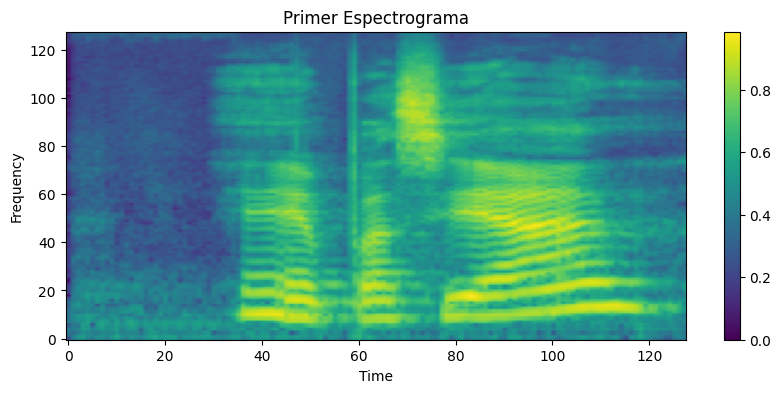

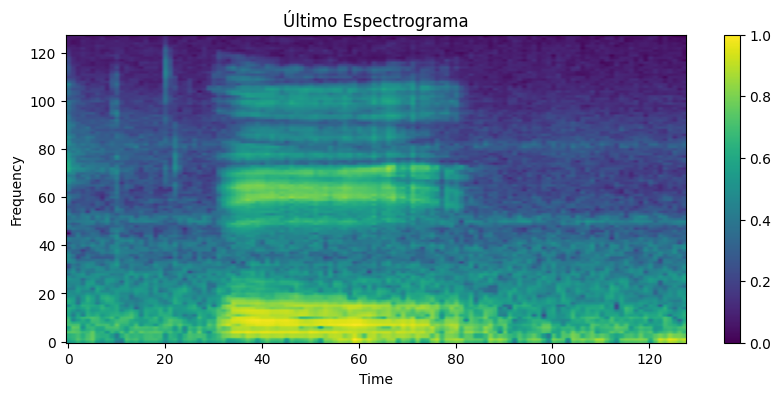

Epoch 1/100
320/320 [==============================] - 7s 19ms/step - loss: 0.7122 - accuracy: 0.5684 - precision: 0.5494 - recall: 0.5571 - f1_score: 0.5700 - val_loss: 0.6650 - val_accuracy: 0.6030 - val_precision: 0.6114 - val_recall: 0.4187 - val_f1_score: 0.4970
Epoch 2/100
320/320 [==============================] - 5s 17ms/step - loss: 0.6301 - accuracy: 0.6463 - precision: 0.6342 - recall: 0.6211 - f1_score: 0.6276 - val_loss: 0.6268 - val_accuracy: 0.6428 - val_precision: 0.6071 - val_recall: 0.6739 - val_f1_score: 0.6387
Epoch 3/100
320/320 [==============================] - 5s 17ms/step - loss: 0.5876 - accuracy: 0.6862 - precision: 0.6752 - recall: 0.6665 - f1_score: 0.6708 - val_loss: 0.6107 - val_accuracy: 0.6612 - val_precision: 0.6324 - val_recall: 0.6614 - val_f1_score: 0.6466
Epoch 4/100
320/320 [==============================] - 5s 17ms/step - loss: 0.5511 - accuracy: 0.7221 - precision: 0.7131 - recall: 0.7038 - f1_score: 0.7084 - val_loss: 0.5965 - val_accuracy: 0.6

LABEL: 100%|██████████| 15990/15990 [00:00<00:00, 579406.84it/s]


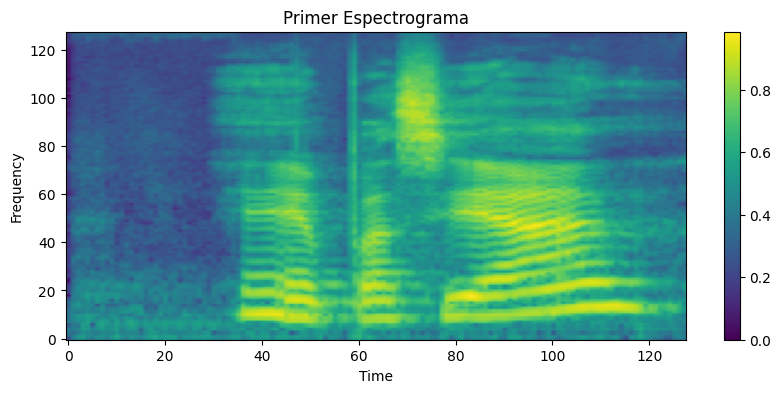

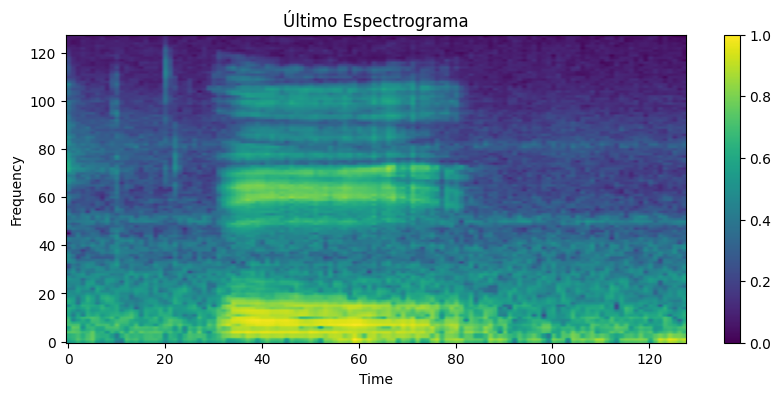

Epoch 1/100
320/320 [==============================] - 43s 126ms/step - loss: 0.7818 - accuracy: 0.5111 - precision: 0.4914 - recall: 0.4625 - f1_score: 0.5493 - val_loss: 0.6967 - val_accuracy: 0.5061 - val_precision: 0.4756 - val_recall: 0.6489 - val_f1_score: 0.5489
Epoch 2/100
320/320 [==============================] - 40s 124ms/step - loss: 0.7398 - accuracy: 0.5039 - precision: 0.4828 - recall: 0.4384 - f1_score: 0.4595 - val_loss: 0.6944 - val_accuracy: 0.5061 - val_precision: 0.4686 - val_recall: 0.4979 - val_f1_score: 0.4828
Epoch 3/100
320/320 [==============================] - 40s 125ms/step - loss: 0.7187 - accuracy: 0.5065 - precision: 0.4858 - recall: 0.4408 - f1_score: 0.4622 - val_loss: 0.6931 - val_accuracy: 0.5135 - val_precision: 0.4712 - val_recall: 0.4143 - val_f1_score: 0.4410
Epoch 4/100
320/320 [==============================] - 40s 124ms/step - loss: 0.7101 - accuracy: 0.5113 - precision: 0.4913 - recall: 0.4467 - f1_score: 0.4679 - val_loss: 0.6935 - val_accur

KeyboardInterrupt: 

In [6]:
import json

def run_experiments():
    architectures = ['CNN_LF', 'reduced_model', 'Spectro_CNN']
    n_splits_options = [5]
    epochs_options = [50]
    window_sizes = [2, 5, 10, 15, 20, 30]

    results = {}
    json_file = 'experiment_results.json'

    # Cargar resultados previos si existen
    if os.path.exists(json_file):
        with open(json_file, 'r') as f:
            results = json.load(f)

    total_experiments = len(architectures) * len(n_splits_options) * len(epochs_options) * len(window_sizes)
    experiment_count = 0

    for architecture in architectures:
        for n_splits in n_splits_options:
            for epochs in epochs_options:
                for window_size in window_sizes:
                    experiment_key = f"{architecture}_splits_{n_splits}_epochs_{epochs}_window_{window_size}"
                    if experiment_key not in results:
                        print(f"Running experiment {experiment_count + 1}/{total_experiments}: {experiment_key}")
                        avg_results = main(architecture=architecture, epochs=epochs, n_splits=n_splits, window_size=window_size)
                        results[experiment_key] = {
                            'Loss': avg_results[0],
                            'Accuracy': avg_results[1],
                            'Precision': avg_results[2],
                            'Recall': avg_results[3],
                            'F1-score': avg_results[4],
                            'Specificity': avg_results[5]
                        }
                        with open(json_file, 'w') as f:
                            json.dump(results, f, indent=4)
                        experiment_count += 1

    plot_experiment_results(results)

def plot_experiment_results(results):
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity']
    plt.figure(figsize=(20, 10))

    for metric in metrics:
        plt.figure(figsize=(20, 10))
        for key, value in results.items():
            plt.plot(key, value[metric], marker='o', label=key)
        plt.title(f'{metric} across different experiments')
        plt.xlabel('Experiment')
        plt.ylabel(metric)
        plt.legend(loc='best')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    # Grafica comparativa de todas las métricas
    plt.figure(figsize=(20, 10))
    for metric in metrics:
        metric_values = [value[metric] for key, value in results.items()]
        plt.plot(list(results.keys()), metric_values, marker='o', label=metric)
    
    plt.title('Comparison of all metrics across different experiments')
    plt.xlabel('Experiment')
    plt.ylabel('Metric Value')
    plt.legend(loc='best')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # Gráfica de línea para diferentes window_size
    for architecture in ['CNN_LF', 'reduced_model', 'Spectro_CNN']:
        for n_splits in [5, 10]:
            for epochs in [50, 100]:
                filtered_results = {k: v for k, v in results.items() if f"{architecture}_splits_{n_splits}_epochs_{epochs}" in k}
                if filtered_results:
                    plt.figure(figsize=(20, 10))
                    for metric in metrics:
                        metric_values = [value[metric] for key, value in filtered_results.items()]
                        window_sizes = [int(key.split('_')[-1].replace('window_', '')) for key in filtered_results.keys()]
                        plt.plot(window_sizes, metric_values, marker='o', label=metric)
                    
                    plt.title(f'Comparison of {architecture} with {n_splits} splits and {epochs} epochs across different window sizes')
                    plt.xlabel('Window Size')
                    plt.ylabel('Metric Value')
                    plt.legend(loc='best')
                    plt.xticks(rotation=90)
                    plt.tight_layout()
                    plt.show()

# Ejecución de los experimentos
run_experiments()



# Gráficas de resultados por combinacion de variables

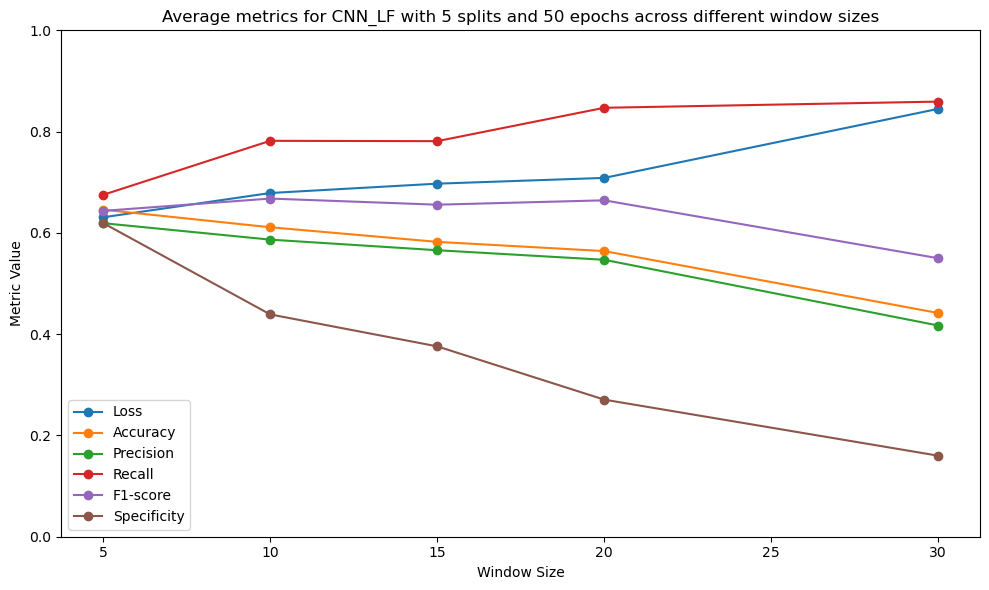

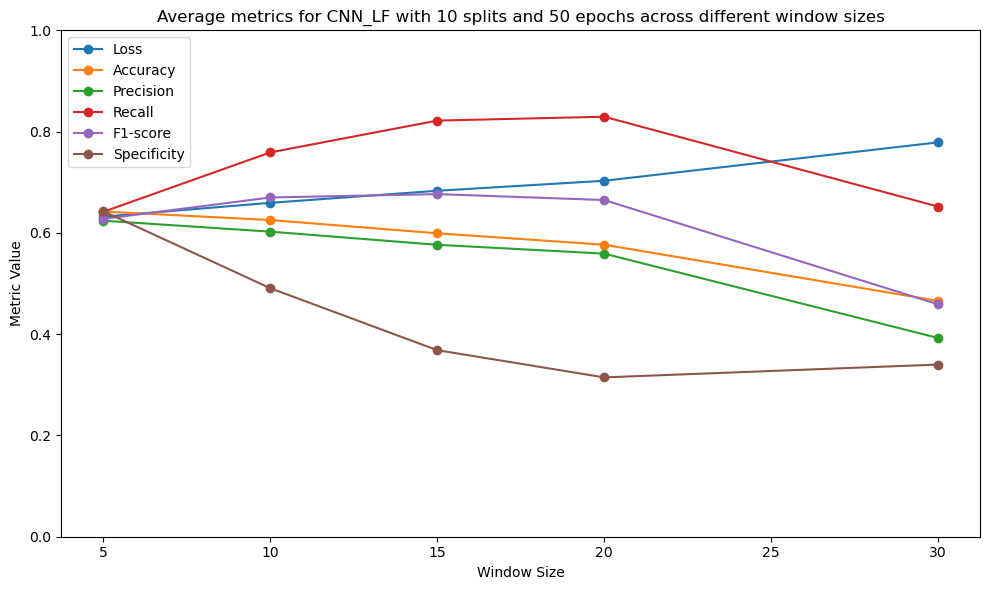

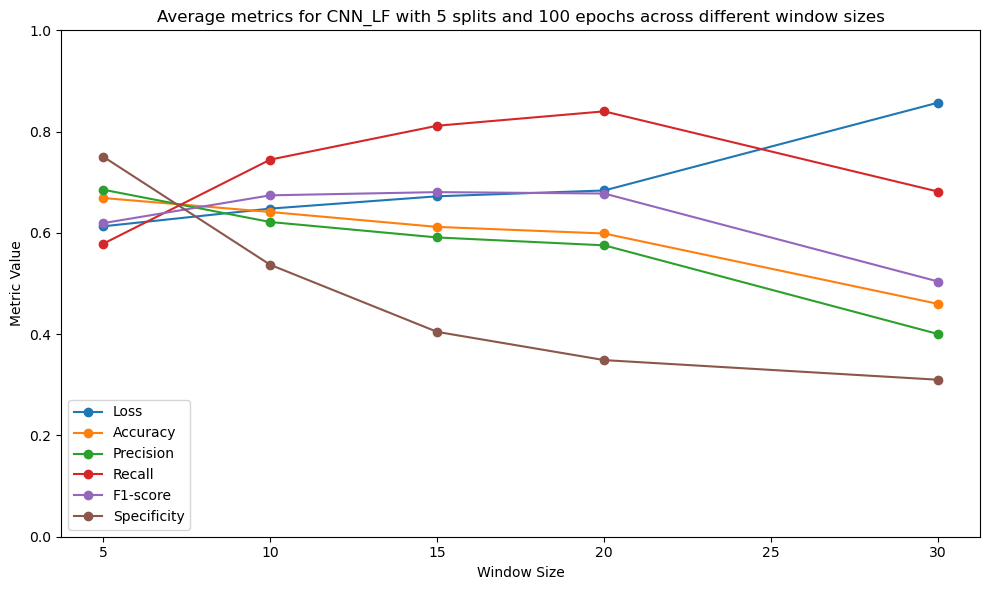

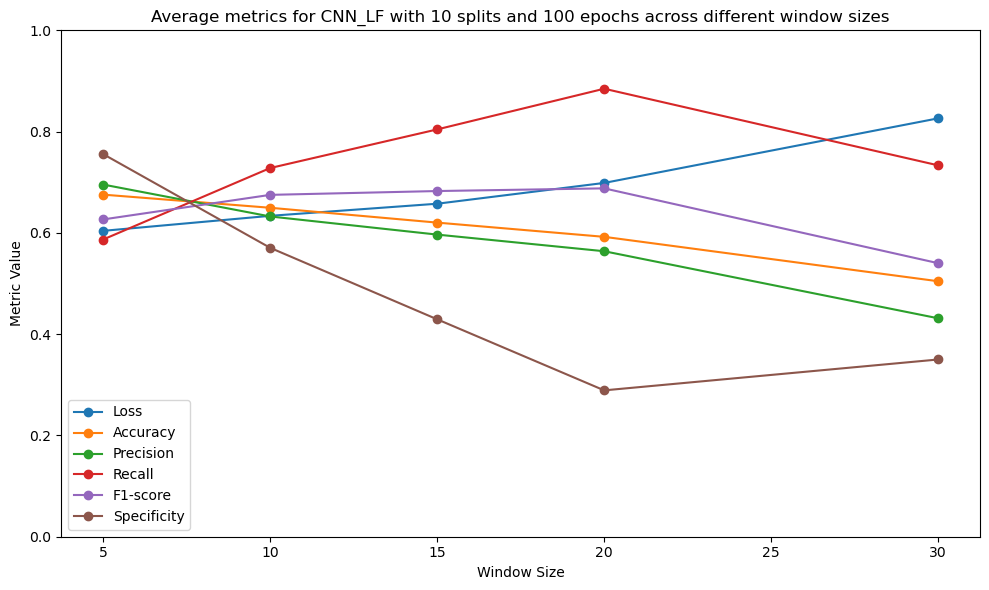

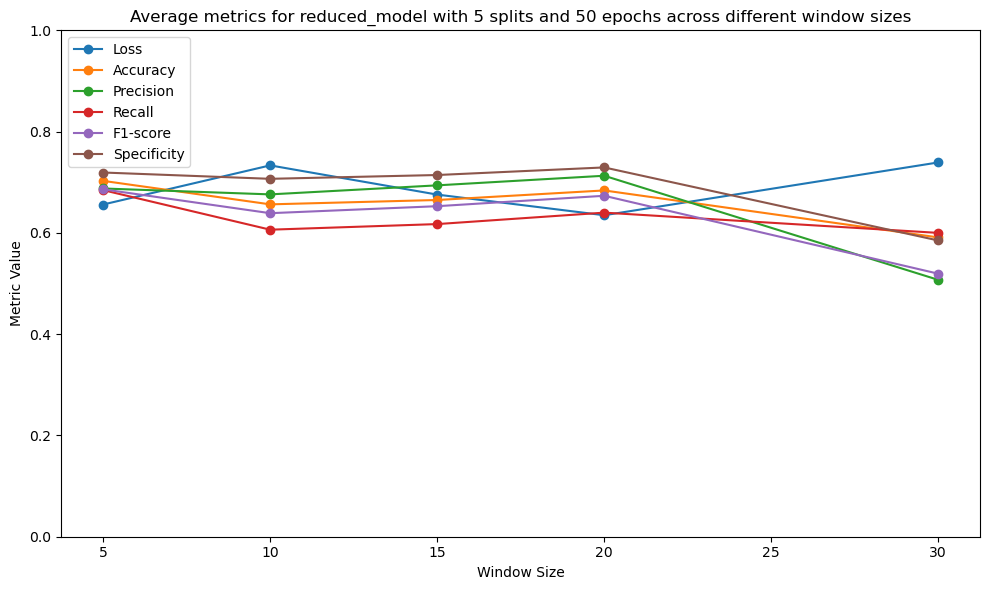

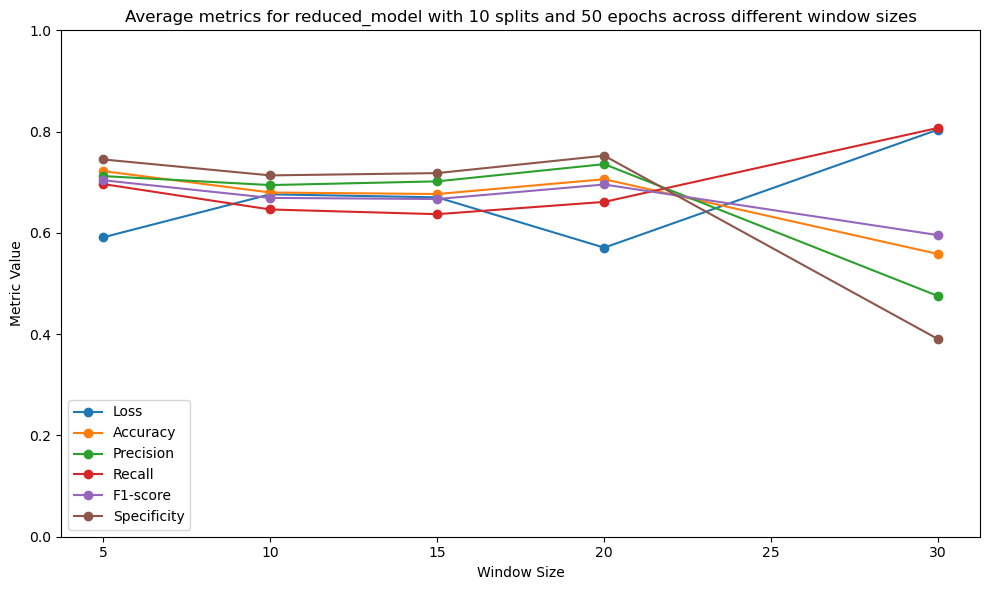

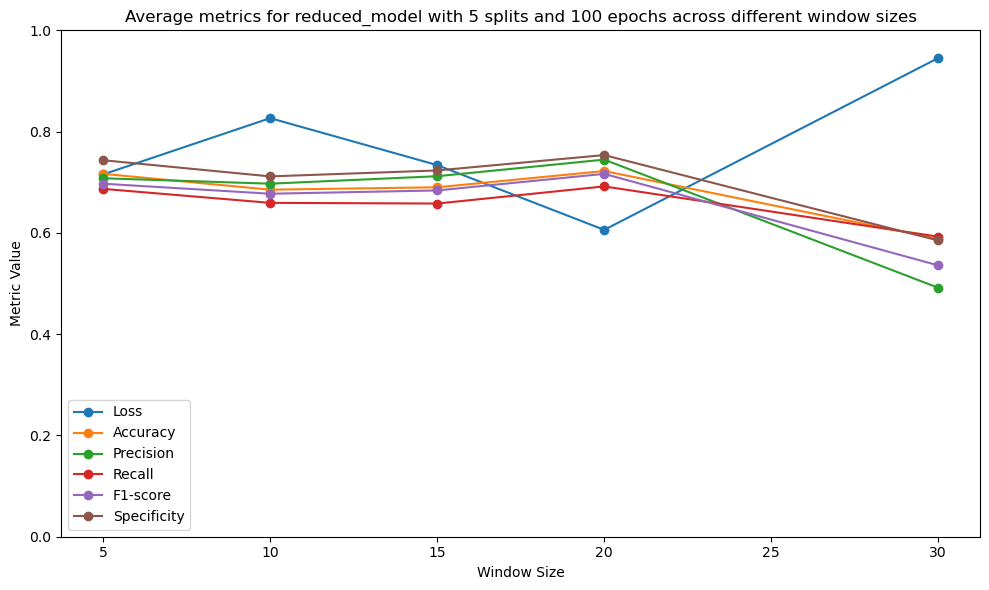

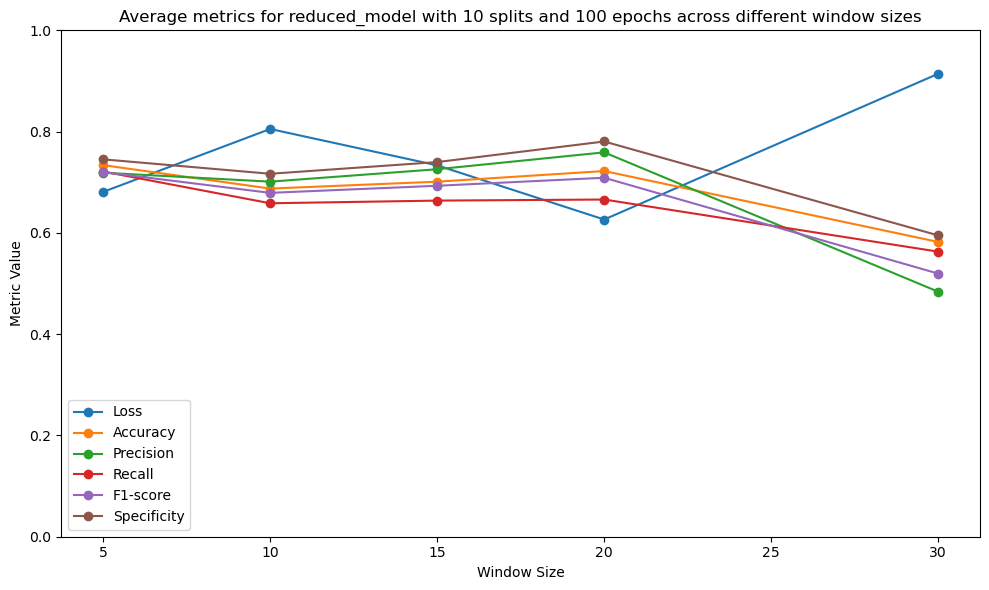

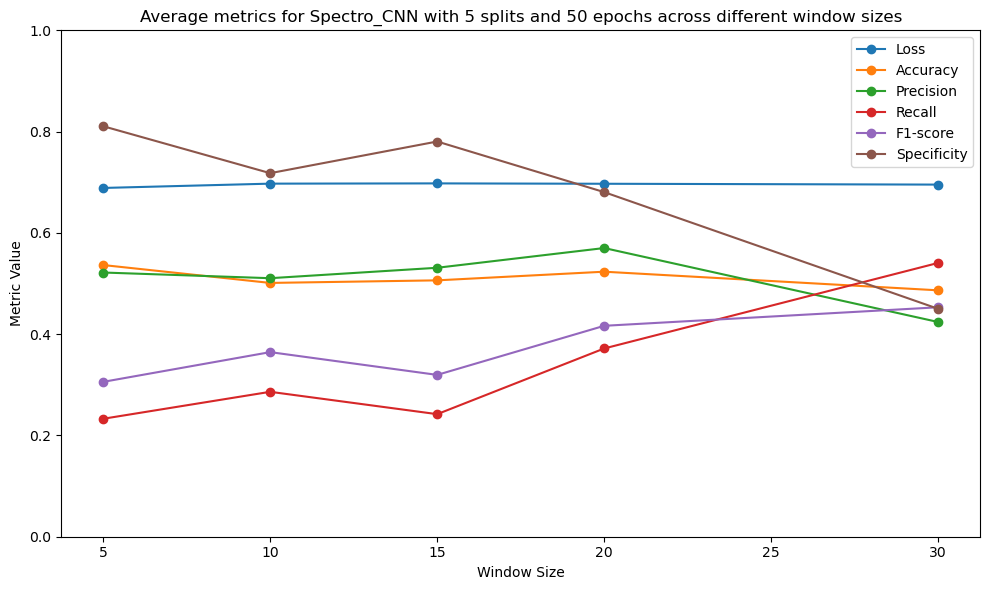

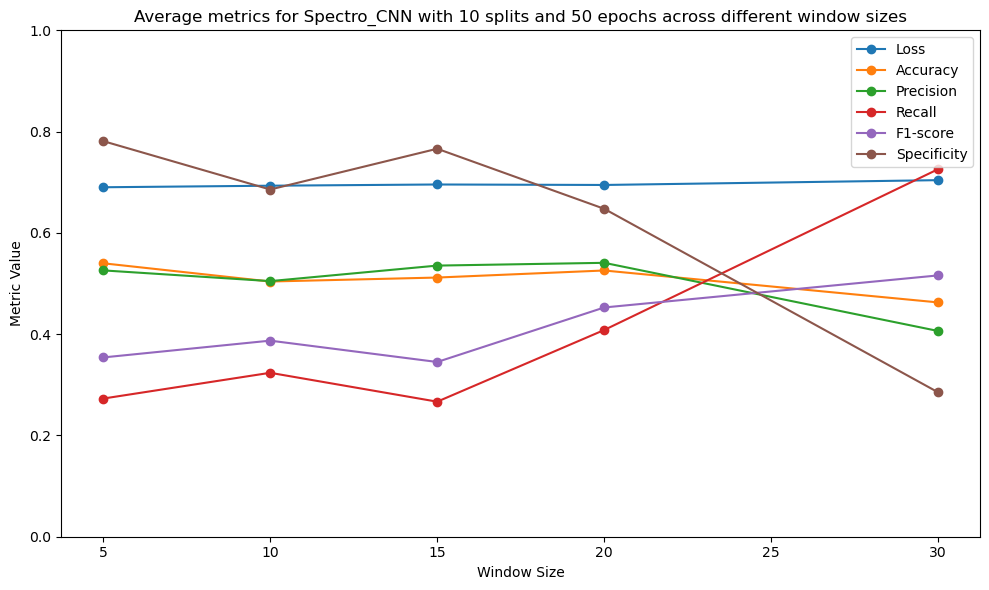

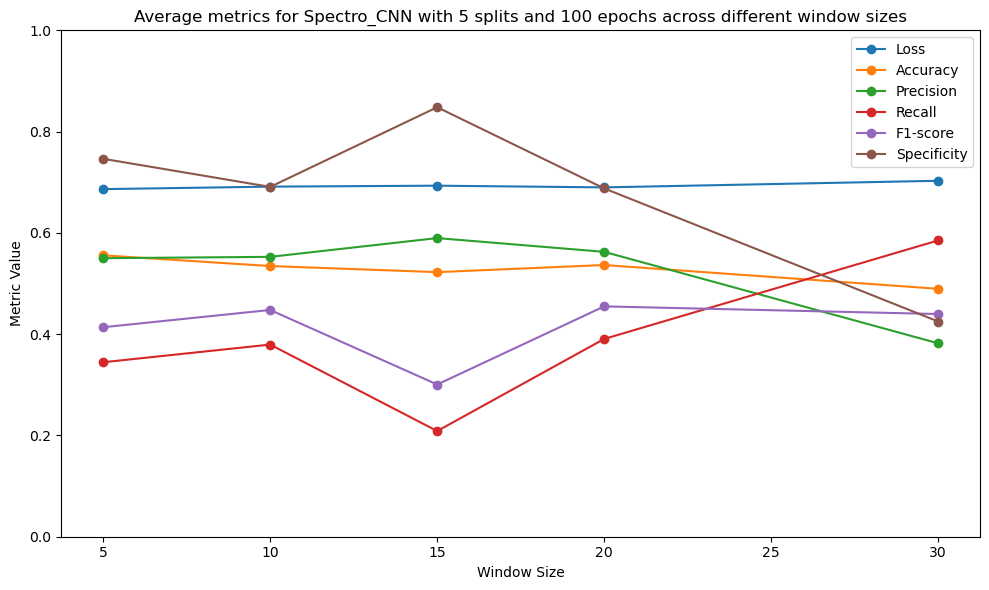

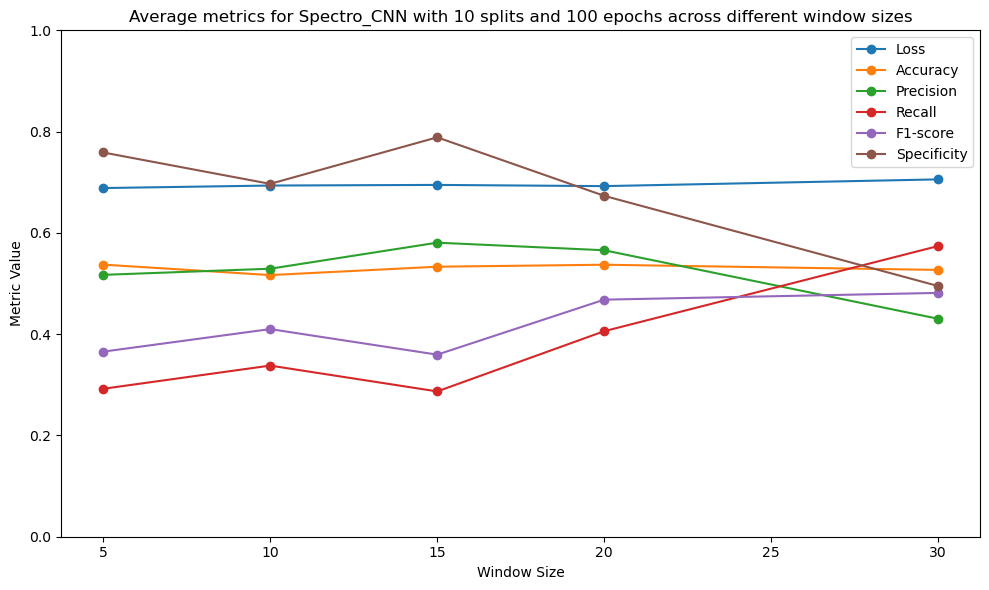

In [7]:
import json
import matplotlib.pyplot as plt
import os
import numpy as np

def calculate_averages(filtered_results, metrics):
    window_sizes = sorted(set(int(key.split('_')[-1].replace('window_', '')) for key in filtered_results.keys()))
    averages = {metric: [] for metric in metrics}
    for window_size in window_sizes:
        for metric in metrics:
            metric_values = [value[metric] for key, value in filtered_results.items() if f"window_{window_size}" in key]
            averages[metric].append(np.mean(metric_values))
    return window_sizes, averages

def plot_average_metrics(results):
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity']
    architectures = ['CNN_LF', 'reduced_model', 'Spectro_CNN']
    epochs_options = [50, 100]
    splits_options = [5, 10]
    
    for architecture in architectures:
        for epochs in epochs_options:
            for splits in splits_options:
                filtered_results = {k: v for k, v in results.items() if f"{architecture}_splits_{splits}_epochs_{epochs}" in k}
                if filtered_results:
                    window_sizes, averages = calculate_averages(filtered_results, metrics)
                    plt.figure(figsize=(10, 6))
                    for metric in metrics:
                        plt.plot(window_sizes, averages[metric], marker='o', linestyle='-', label=metric)
                    plt.ylim(0, 1)
                    plt.title(f'Average metrics for {architecture} with {splits} splits and {epochs} epochs across different window sizes')
                    plt.xlabel('Window Size')
                    plt.ylabel('Metric Value')
                    plt.legend(loc='best')
                    plt.tight_layout()
                    plt.show()

# Cargar resultados del archivo JSON
json_file = 'experiment_results.json'
if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        results = json.load(f)
        plot_average_metrics(results)
else:
    print("No se encontraron resultados previos.")


# Gráficas de resultados promedio por ventana

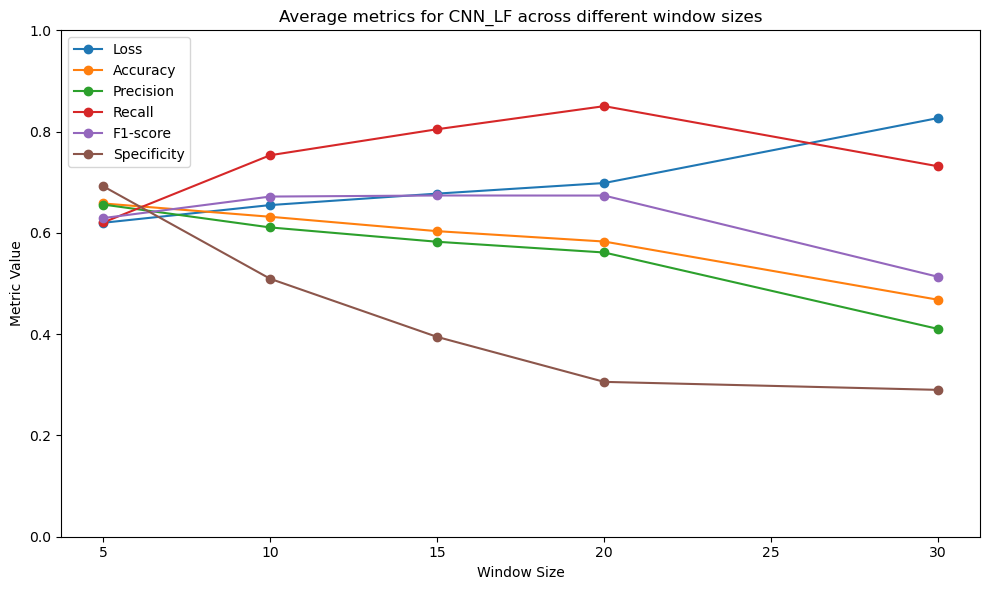

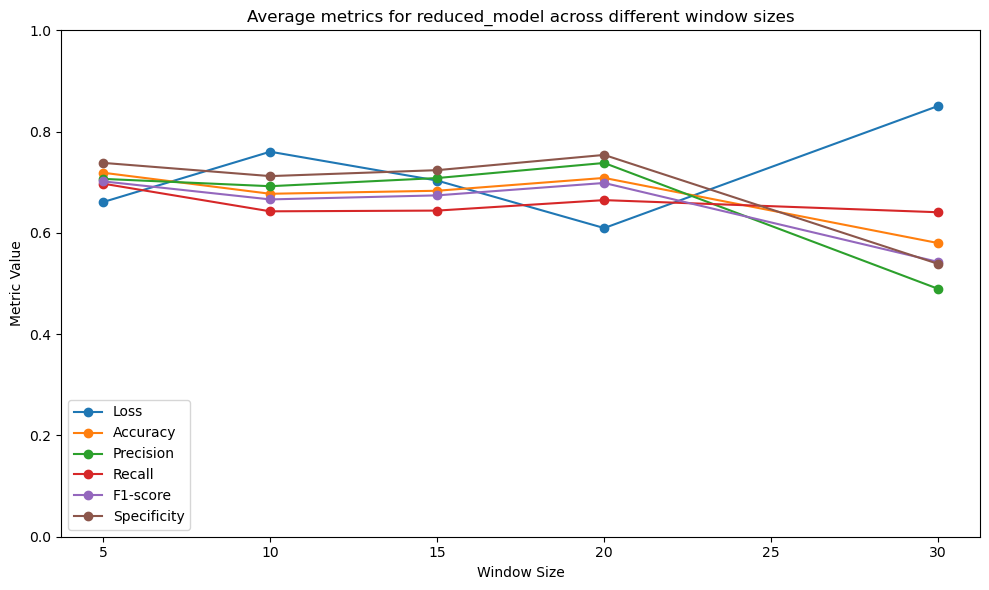

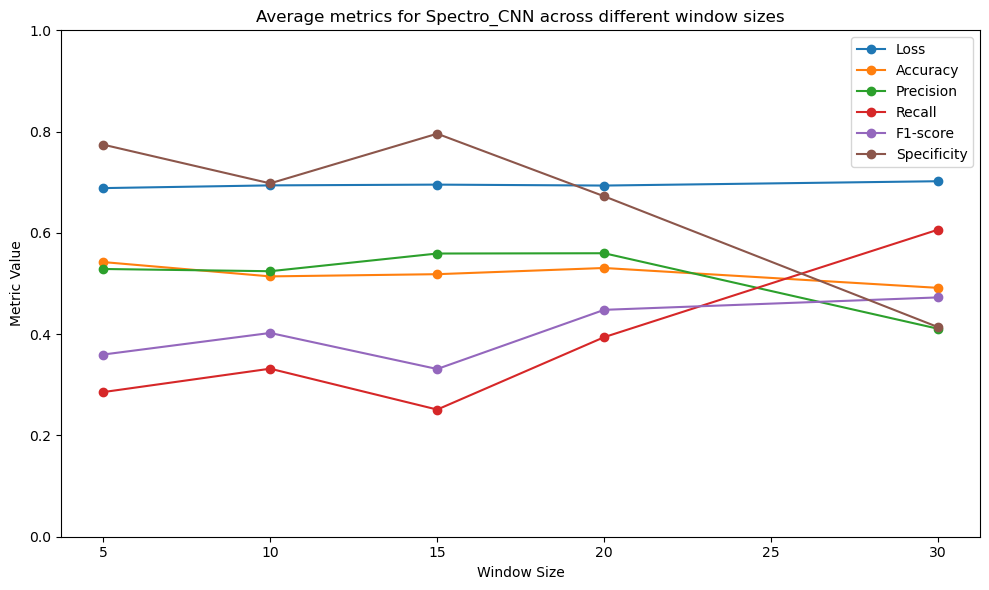

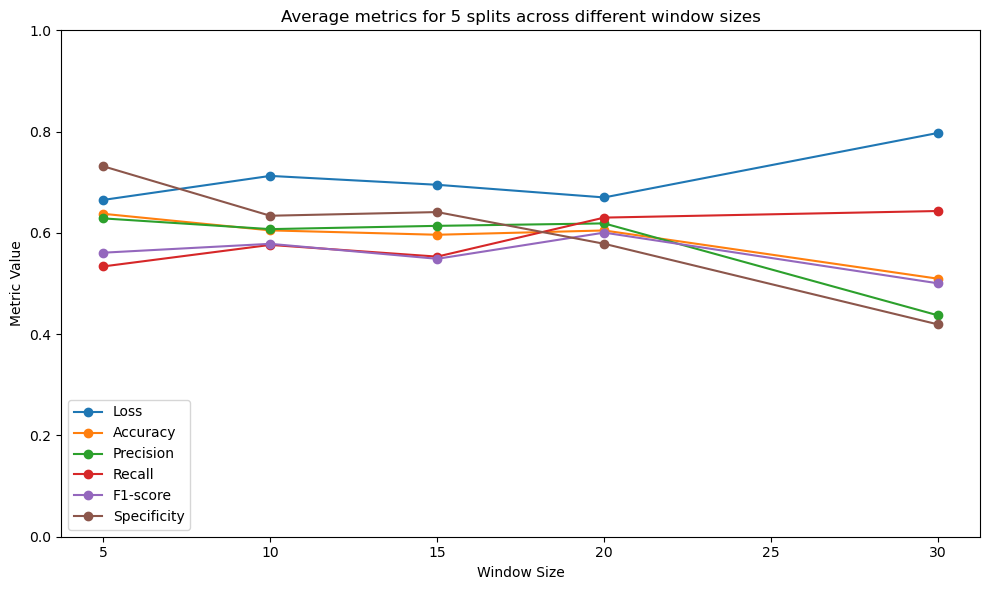

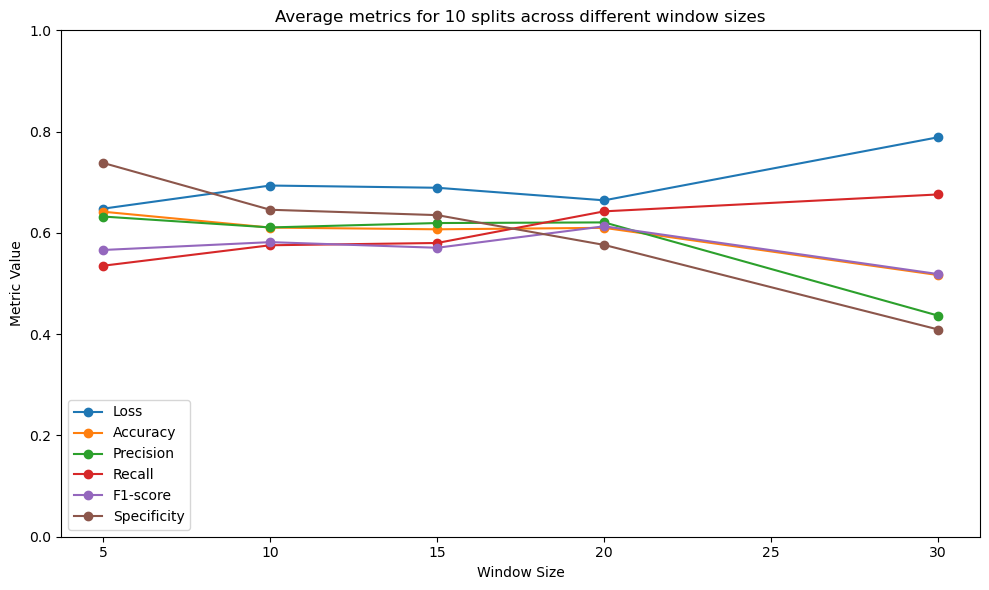

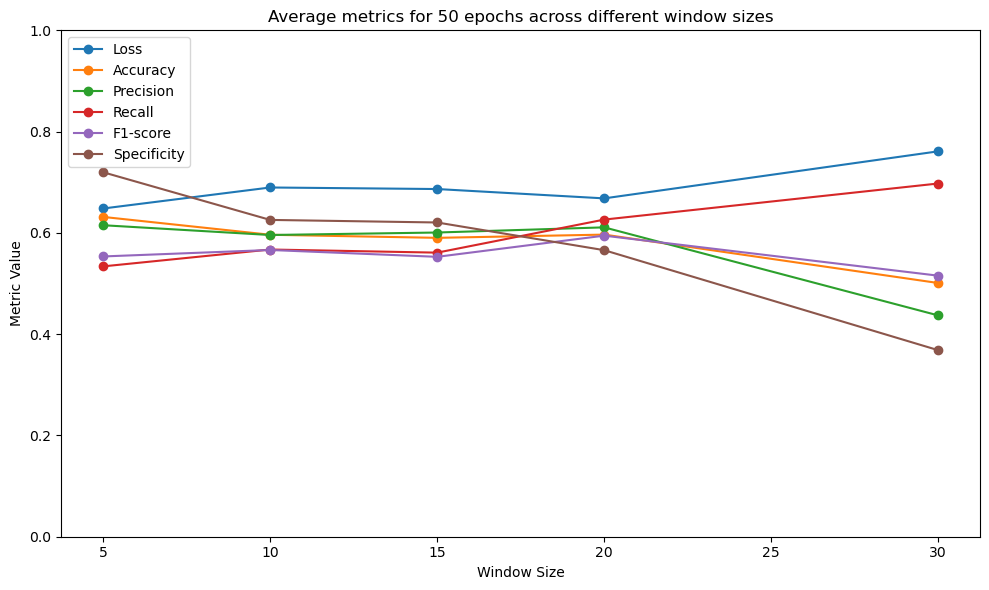

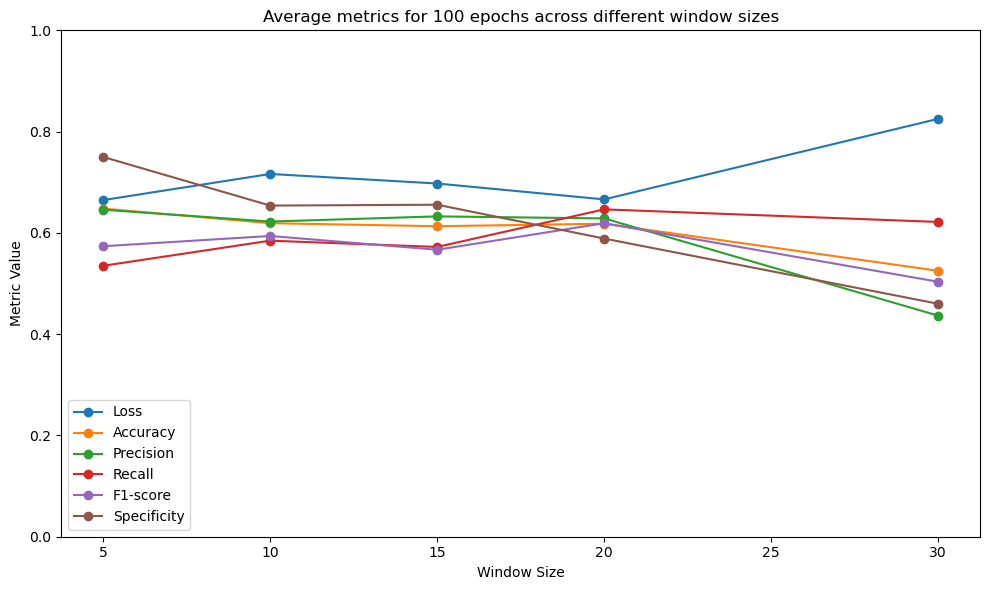

In [8]:
import json
import matplotlib.pyplot as plt
import os
import numpy as np

def calculate_averages(filtered_results, metrics):
    window_sizes = sorted(set(int(key.split('_')[-1].replace('window_', '')) for key in filtered_results.keys()))
    averages = {metric: [] for metric in metrics}
    for window_size in window_sizes:
        for metric in metrics:
            metric_values = [value[metric] for key, value in filtered_results.items() if f"window_{window_size}" in key]
            averages[metric].append(np.mean(metric_values))
    return window_sizes, averages

def plot_average_metrics_by_model(results):
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity']
    architectures = ['CNN_LF', 'reduced_model', 'Spectro_CNN']
    
    for architecture in architectures:
        filtered_results = {k: v for k, v in results.items() if architecture in k}
        if filtered_results:
            window_sizes, averages = calculate_averages(filtered_results, metrics)
            plt.figure(figsize=(10, 6))
            for metric in metrics:
                plt.plot(window_sizes, averages[metric], marker='o', linestyle='-', label=metric)
            plt.ylim(0, 1)
            plt.title(f'Average metrics for {architecture} across different window sizes')
            plt.xlabel('Window Size')
            plt.ylabel('Metric Value')
            plt.legend(loc='best')
            plt.tight_layout()
            plt.show()

def plot_average_metrics_by_splits(results):
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity']
    splits_options = [5, 10]
    
    for splits in splits_options:
        filtered_results = {k: v for k, v in results.items() if f"splits_{splits}_" in k}
        if filtered_results:
            window_sizes, averages = calculate_averages(filtered_results, metrics)
            plt.figure(figsize=(10, 6))
            for metric in metrics:
                plt.plot(window_sizes, averages[metric], marker='o', linestyle='-', label=metric)
            plt.ylim(0, 1)
            plt.title(f'Average metrics for {splits} splits across different window sizes')
            plt.xlabel('Window Size')
            plt.ylabel('Metric Value')
            plt.legend(loc='best')
            plt.tight_layout()
            plt.show()

def plot_average_metrics_by_epochs(results):
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity']
    epochs_options = [50, 100]
    
    for epochs in epochs_options:
        filtered_results = {k: v for k, v in results.items() if f"epochs_{epochs}_" in k}
        if filtered_results:
            window_sizes, averages = calculate_averages(filtered_results, metrics)
            plt.figure(figsize=(10, 6))
            for metric in metrics:
                plt.plot(window_sizes, averages[metric], marker='o', linestyle='-', label=metric)
            plt.ylim(0, 1)
            plt.title(f'Average metrics for {epochs} epochs across different window sizes')
            plt.xlabel('Window Size')
            plt.ylabel('Metric Value')
            plt.legend(loc='best')
            plt.tight_layout()
            plt.show()

def plot_experiment_results_general(results):
    plot_average_metrics_by_model(results)
    plot_average_metrics_by_splits(results)
    plot_average_metrics_by_epochs(results)

# Cargar resultados del archivo JSON
json_file = 'experiment_results.json'
if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        results = json.load(f)
        plot_experiment_results_general(results)
else:
    print("No se encontraron resultados previos.")


# Representar Resultados en una Tabla y Realizar la Prueba de Friedman

## Qué es la prueba de Friedman

Es una prueba estadística no paramétrica que se utiliza para detectar diferencias en tratamientos a través de múltiples pruebas repetidas. Es una alternativa a la ANOVA de medidas repetidas cuando no se cumplen las suposiciones de normalidad.

### ¿Qué Nos Dice la Prueba de Friedman?

1. **Estadístico de Friedman (statistic)**:
    - Este valor mide la dispersión de las clasificaciones de las diferentes configuraciones de ventana de tiempo.
    - Un valor más alto indica una mayor dispersión y, por lo tanto, mayores diferencias entre las configuraciones de ventana de tiempo.

2. **Valor p (p-value)**:
    - Indica la probabilidad de obtener los resultados observados, asumiendo que no hay diferencias reales entre las configuraciones (hipótesis nula).
    - Un valor p bajo (típicamente < 0.05) indica que hay diferencias significativas entre las configuraciones de ventana de tiempo.

### Conclusiones Basadas en la Prueba de Friedman

- **Si el valor p es menor que 0.05**: 
    - Hay diferencias significativas entre las configuraciones de ventana de tiempo para la métrica evaluada.
    - Esto sugiere que el tamaño de la ventana de tiempo afecta significativamente el rendimiento del modelo para esa métrica.

- **Si el valor p es mayor que 0.05**:
    - No hay diferencias significativas entre las configuraciones de ventana de tiempo para la métrica evaluada.
    - Esto sugiere que el tamaño de la ventana de tiempo no tiene un efecto significativo en el rendimiento del modelo para esa métrica.



## Implementando la prueba de Friedman

In [9]:
import json
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare

def parse_experiment_key(key):
    parts = key.split('_')
    architecture = f"{parts[0]}_{parts[1]}"
    splits = int(parts[3])
    epochs = int(parts[5])
    window_size = int(parts[7])
    return architecture, splits, epochs, window_size

def generate_results_table(results):
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity']
    table_data = []

    for key, value in results.items():
        architecture, splits, epochs, window_size = parse_experiment_key(key)
        row = [architecture, splits, epochs, window_size]
        row.extend([value[metric] for metric in metrics])
        table_data.append(row)
    
    columns = ['Architecture', 'Splits', 'Epochs', 'Window Size'] + metrics
    results_df = pd.DataFrame(table_data, columns=columns)
    return results_df

def perform_friedman_test(results_df):
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity']
    
    for metric in metrics:
        data = []
        for architecture in results_df['Architecture'].unique():
            arch_data = results_df[results_df['Architecture'] == architecture][metric].values
            data.append(arch_data)
        
        statistic, p_value = friedmanchisquare(*data)
        print(f'Friedman test for {metric}: statistic={statistic}, p-value={p_value}')

# Cargar resultados del archivo JSON
json_file = 'experiment_results.json'
if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        results = json.load(f)
        results_df = generate_results_table(results)
        results_df
        perform_friedman_test(results_df)
else:
    print("No se encontraron resultados previos.")


Friedman test for Loss: statistic=1.9000000000000057, p-value=0.3867410234545001
Friedman test for Accuracy: statistic=33.60000000000002, p-value=5.056531348335465e-08
Friedman test for Precision: statistic=31.600000000000023, p-value=1.3745077279213825e-07
Friedman test for Recall: statistic=24.69999999999999, p-value=4.329753266093003e-06
Friedman test for F1-score: statistic=29.100000000000023, p-value=4.797503368127275e-07
Friedman test for Specificity: statistic=21.69999999999999, p-value=1.940460788990955e-05


In [10]:
results_df

,Architecture,Splits,Epochs,Window Size,Loss,Accuracy,Precision,Recall,F1-score,Specificity
0,CNN_LF,5,50,5,0.630778,0.645840,0.619152,0.675134,0.643486,0.619386
1,CNN_LF,5,50,10,0.678752,0.611111,0.586686,0.781818,0.667773,0.439044
2,CNN_LF,5,50,15,0.697200,0.582288,0.565782,0.781159,0.655693,0.375940
3,CNN_LF,5,50,20,0.708577,0.564072,0.546897,0.847059,0.664312,0.270732
4,CNN_LF,5,50,30,0.844950,0.441791,0.417086,0.859259,0.549945,0.160000
5,CNN_LF,10,50,5,0.632090,0.642190,0.624062,0.641503,0.627572,0.642811
6,CNN_LF,10,50,10,0.659354,0.625397,0.602488,0.758893,0.669925,0.490837
7,CNN_LF,10,50,15,0.683183,0.599262,0.576492,0.821739,0.676568,0.368421
8,CNN_LF,10,50,20,0.702923,0.576647,0.559057,0.829412,0.664904,0.314634
9,CNN_LF,10,50,30,0.778818,0.465672,0.392394,0.651852,0.458882,0.340000


## Posthocs

### Qué es
Se aplica la prueba de Dunn con ajuste de Bonferroni, que es una técnica estadística utilizada para realizar comparaciones múltiples después de encontrar resultados significativos en un análisis de varianza (ANOVA) o en otras pruebas no paramétricas como el test de Kruskal-Wallis. Esta prueba combina la metodología de la prueba de Dunn para comparaciones múltiples no paramétricas con el ajuste de Bonferroni para controlar la tasa de errores tipo I.

### Prueba de Dunn

La prueba de Dunn es una prueba post hoc no paramétrica que se utiliza para comparar todas las posibles combinaciones de pares de grupos después de realizar un análisis de varianza no paramétrico como el test de Kruskal-Wallis. Es útil cuando los datos no cumplen con los supuestos de normalidad necesarios para realizar un ANOVA paramétrico.

### Ajuste de Bonferroni

El ajuste de Bonferroni es una técnica utilizada para controlar la tasa de errores tipo I (falsos positivos) cuando se realizan múltiples comparaciones. La idea básica es ajustar el nivel de significancia (α) dividiéndolo por el número de comparaciones (k) para mantener la probabilidad global de cometer un error tipo I dentro del límite deseado.

\[ \alpha_{\text{ajustado}} = \frac{\alpha}{k} \]

Donde:
- \(\alpha\) es el nivel de significancia original (por ejemplo, 0.05).
- \(k\) es el número de comparaciones.

### Prueba de Dunn con Ajuste de Bonferroni

Cuando se combinan, la prueba de Dunn con ajuste de Bonferroni implica los siguientes pasos:

1. **Realización del Test de Kruskal-Wallis**: Primero, se lleva a cabo el test de Kruskal-Wallis para determinar si existen diferencias significativas entre las medianas de los grupos.
2. **Aplicación de la Prueba de Dunn**: Si el test de Kruskal-Wallis resulta significativo, se procede con la prueba de Dunn para comparar todas las combinaciones de pares de grupos.
3. **Ajuste de Bonferroni**: Se aplica el ajuste de Bonferroni a los niveles de significancia de las comparaciones múltiples para controlar la tasa de errores tipo I.

### Ventajas y Consideraciones

- **Control de Errores Tipo I**: El ajuste de Bonferroni reduce la probabilidad de falsos positivos cuando se realizan múltiples comparaciones.
- **Aplicabilidad**: La prueba de Dunn es adecuada para datos no paramétricos, lo que la hace útil en situaciones donde los datos no cumplen con los supuestos de normalidad.
- **Conservadorismo**: El ajuste de Bonferroni es bastante conservador, lo que significa que puede aumentar la probabilidad de errores tipo II (falsos negativos), es decir, puede no detectar diferencias significativas cuando realmente existen.

En resumen, la prueba de Dunn con ajuste de Bonferroni es una técnica robusta y conservadora para realizar comparaciones múltiples en datos no paramétricos, asegurando que la tasa de errores tipo I se mantenga bajo control.

### Código

In [11]:
import pandas as pd
from scipy.stats import friedmanchisquare

def prepare_data_for_friedman(results_df, metric):
    data = []
    for _, group in results_df.groupby(['Architecture', 'Splits', 'Epochs']):
        windows_data = [group[group['Window Size'] == window][metric].values for window in sorted(group['Window Size'].unique())]
        if all(len(w) > 0 for w in windows_data):  # Ensure all windows have data
            data.append(windows_data)
    return data
def perform_friedman_test_on_windows(prepared_data):
    # Convert the data to the correct format for friedmanchisquare
    formatted_data = [list(treatment) for treatment in zip(*prepared_data)]
    statistic, p_value = friedmanchisquare(*formatted_data)
    return statistic, p_value


def perform_friedman_tests(results_df):
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity']
    for metric in metrics:
        prepared_data = prepare_data_for_friedman(results_df, metric)
        if prepared_data:
            statistic, p_value = perform_friedman_test_on_windows(prepared_data)
            print(f'Friedman test for window sizes - {metric}: statistic={statistic}, p-value={p_value}')
        else:
            print(f'No data available for metric {metric}')

# Cargar resultados del archivo JSON
json_file = 'experiment_results.json'
if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        results = json.load(f)
        results_df = generate_results_table(results)
        perform_friedman_tests(results_df)
else:
    print("No se encontraron resultados previos.")

Friedman test for window sizes - Loss: statistic=[30.06666667], p-value=[4.74384085e-06]
Friedman test for window sizes - Accuracy: statistic=[36.53333333], p-value=[2.24747075e-07]
Friedman test for window sizes - Precision: statistic=[27.], p-value=[1.98789068e-05]
Friedman test for window sizes - Recall: statistic=[12.33333333], p-value=[0.01503723]
Friedman test for window sizes - F1-score: statistic=[10.33333333], p-value=[0.03517189]
Friedman test for window sizes - Specificity: statistic=[28.26666667], p-value=[1.10130071e-05]


In [12]:
# Función para ejecutar todas las pruebas
def run_all_tests(results_df):
    print("\nFriedman tests for window sizes:")
    friedman_window_results = perform_friedman_tests_on_windows(results_df)
    
    print("\nFriedman tests for architectures:")
    friedman_architecture_results = perform_friedman_test_on_architectures(results_df)
    
    print("\nWilcoxon tests for epochs:")
    wilcoxon_epoch_results = perform_wilcoxon_test_on_epochs(results_df)
    
    # Crear DataFrames separados para los resultados de Friedman y Wilcoxon
    friedman_results_df = pd.DataFrame(friedman_window_results + friedman_architecture_results, columns=['Metric', 'Test', 'Statistic', 'p-value', 'GroupBy'])
    wilcoxon_results_df = pd.DataFrame(wilcoxon_epoch_results, columns=['Metric', 'Test', 'Statistic', 'p-value', 'GroupBy'])

    # Guardar resultados a CSV
    save_results_to_csv(results_df, 'experiment_results.csv')
    save_results_to_csv(friedman_results_df, 'friedman_results.csv')
    save_results_to_csv(wilcoxon_results_df, 'wilcoxon_results.csv')
    
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity']
    posthoc_results = []
    for metric in metrics:
        print(f"\nPosthoc Dunn test results for {metric}:")
        posthoc_result = perform_posthoc_test(results_df, metric)
        posthoc_results.append(posthoc_result)
        plot_results_table(results_df, metric, 'Window Size')
        plot_results_table(results_df, metric, 'Architecture')
        plot_results_table(results_df, metric, 'Epochs')

    # Consolidar resultados post-hoc en un solo DataFrame y guardar
    posthoc_results_df = pd.concat(posthoc_results, ignore_index=True)
    posthoc_results_df.to_csv('posthoc_results.csv', index=False)
    
    # Generar diagramas de distancia crítica
    for metric in metrics:
        for comparison in ['Window Size', 'Architecture', 'Epochs']:
            if comparison in results_df.columns:  # Verifica si la columna existe en el DataFrame
                data = results_df.pivot_table(values=metric, index='Architecture', columns=comparison, aggfunc='mean')
                labels = data.columns
                ranks = data.mean().rank(ascending=False).values
                generate_critical_distance_diagram(metric, labels, ranks)
            else:
                print(f"Column {comparison} not found in DataFrame")

# Cargar resultados del archivo JSON
json_file = 'experiment_results.json'
if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        results = json.load(f)
        results_df = generate_results_table(results)
        print(f"Unique Epochs: {results_df['Epochs'].unique()}")  # Debugging line
        run_all_tests(results_df)
else:
    print("No se encontraron resultados previos.")


Unique Epochs: [ 50 100]

Friedman tests for window sizes:


NameError: name 'perform_friedman_tests_on_windows' is not defined


Running Friedman tests by Window Size:


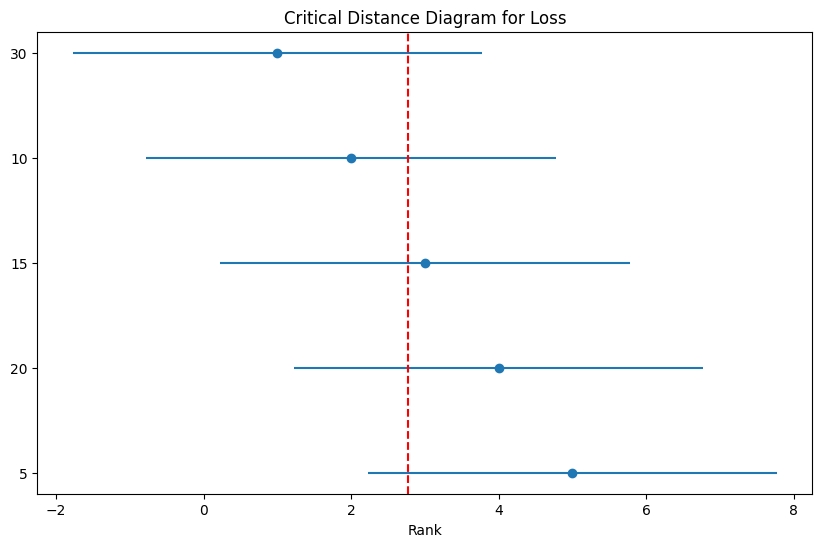

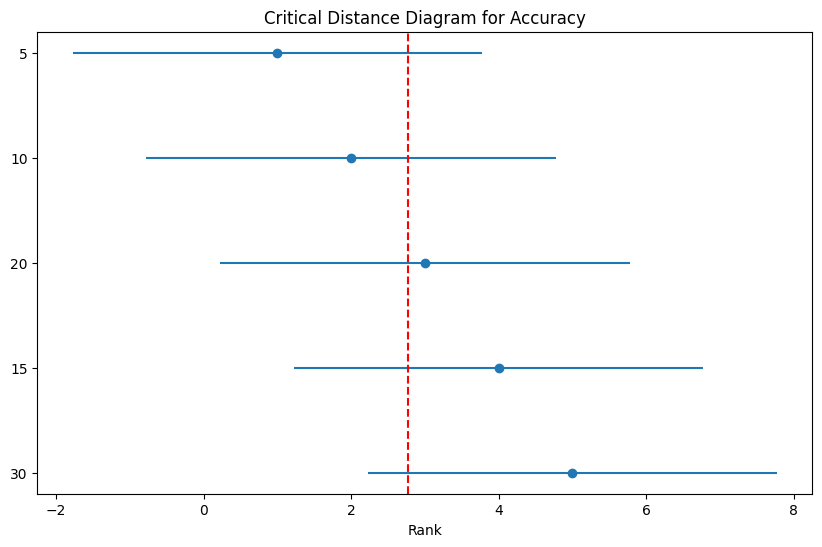

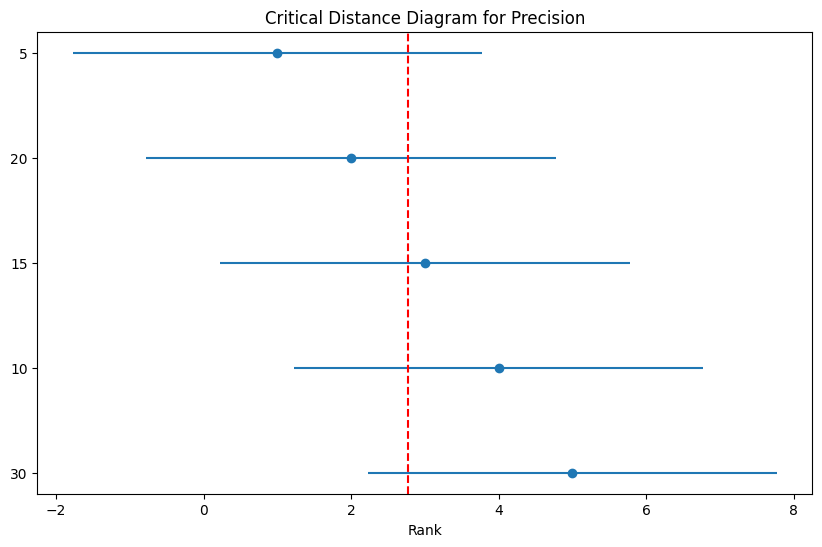

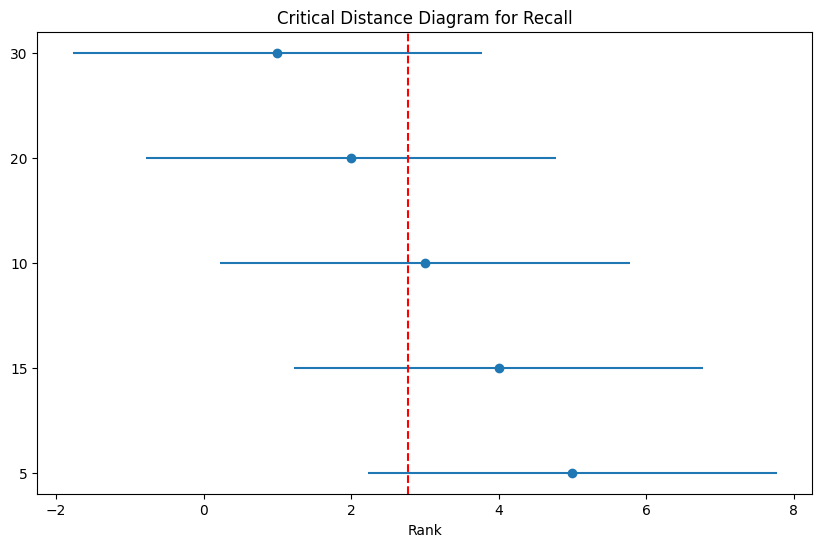

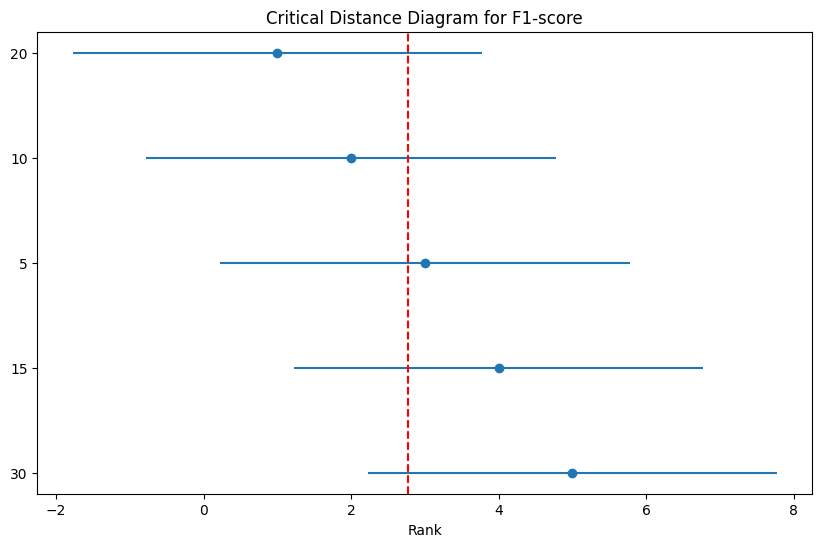

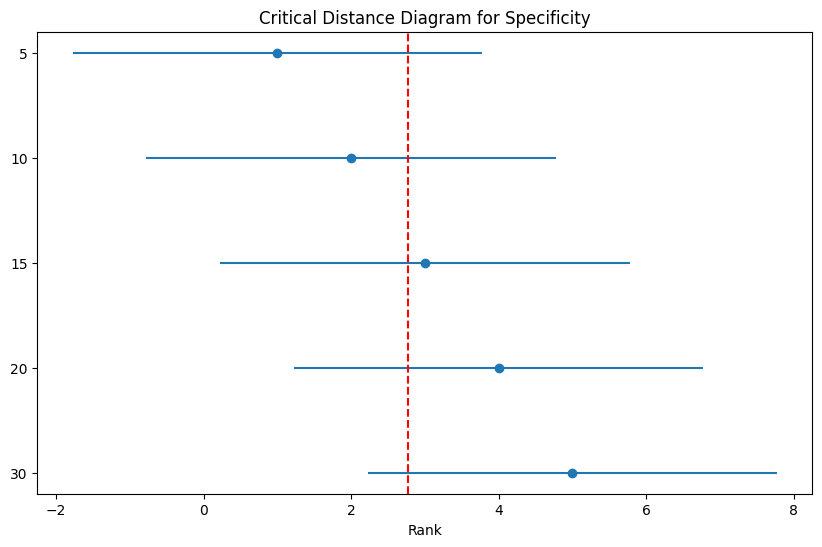

In [ ]:
import json
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_dunn
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

# Función para cargar y preparar los datos
def parse_experiment_key(key):
    parts = key.split('_')
    architecture = f"{parts[0]}_{parts[1]}"
    splits = int(parts[3])
    epochs = int(parts[5])
    window_size = int(parts[7])
    return architecture, splits, epochs, window_size

def generate_results_table(results):
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity']
    table_data = []

    for key, value in results.items():
        architecture, splits, epochs, window_size = parse_experiment_key(key)
        row = [architecture, splits, epochs, window_size]
        row.extend([value[metric] for metric in metrics])
        table_data.append(row)
    
    columns = ['Architecture', 'Splits', 'Epochs', 'Window Size'] + metrics
    results_df = pd.DataFrame(table_data, columns=columns)
    return results_df

# Función para determinar si el resultado es significativo
def is_significant(p_value, num_comparisons, alpha=0.05):
    significance_level = alpha / num_comparisons
    return p_value < significance_level, significance_level

# Función para la prueba de Friedman por Window Size
def perform_friedman_test_on_window_size(results_df, metric, architecture_group=None):
    if architecture_group:
        df_filtered = results_df[results_df['Architecture'] == architecture_group]
    else:
        df_filtered = results_df
    
    window_groups = []
    for window_size in sorted(df_filtered['Window Size'].unique()):
        group_data = df_filtered[df_filtered['Window Size'] == window_size][metric].values
        if len(group_data) > 0:
            window_groups.append(group_data)
    
    if len(window_groups) < 2:
        return metric, "Friedman Test", "Not enough data", "", "Window Size", architecture_group or "All Architectures", "No", ""

    statistic, p_value = friedmanchisquare(*window_groups)
    num_comparisons = len(window_groups)
    significant, significance_level = is_significant(p_value, num_comparisons)
    
    return metric, "Friedman Test", float(statistic), float(p_value), "Window Size", architecture_group or "All Architectures", "Yes" if significant else "No", significance_level

# Función para la prueba post-hoc de Dunn
def perform_posthoc_test(results_df, metric, architecture_group=None):
    if architecture_group:
        df_filtered = results_df[results_df['Architecture'] == architecture_group]
    else:
        df_filtered = results_df
    
    data = []
    groups = []
    for window_size in sorted(df_filtered['Window Size'].unique()):
        window_data = df_filtered[df_filtered['Window Size'] == window_size][metric].values
        data.extend(window_data)
        groups.extend([window_size] * len(window_data))
    
    # Convert data and groups to DataFrame for posthoc_dunn
    data_array = np.array(data)
    groups_array = np.array(groups)
    
    posthoc_df = pd.DataFrame({'data': data_array, 'groups': groups_array})
    posthoc_results = posthoc_dunn(posthoc_df, val_col='data', group_col='groups', p_adjust='bonferroni')
    
    posthoc_results_melted = posthoc_results.reset_index().melt(id_vars='index')
    posthoc_results_melted.columns = ['Group1', 'Group2', 'p-value']
    posthoc_results_melted['Metric'] = metric
    posthoc_results_melted['Test'] = 'Dunn Posthoc Test'
    posthoc_results_melted['Statistic'] = ''
    
    num_comparisons = len(posthoc_results_melted)
    posthoc_results_melted['Significance'] = posthoc_results_melted['p-value'].apply(lambda p: "Yes" if p < (0.05 / num_comparisons) else "No")
    posthoc_results_melted['Significance Level'] = 0.05 / num_comparisons
    
    return posthoc_results_melted

# Función para los diagramas de distancia crítica
def generate_critical_distance_diagram(metric, labels, ranks, alpha=0.05):
    plt.figure(figsize=(10, 6))
    # Calculate critical distance
    k = len(ranks)
    cd = scipy.stats.t.ppf(1 - alpha / 2, k - 1) * np.sqrt(k * (k + 1) / (6 * len(labels)))
    
    # Sort by rank
    sorted_idx = np.argsort(ranks)
    sorted_ranks = np.array(ranks)[sorted_idx]
    sorted_labels = np.array(labels)[sorted_idx]
    
    plt.errorbar(sorted_ranks, np.arange(len(ranks)), xerr=cd, fmt='o')
    plt.yticks(np.arange(len(ranks)), sorted_labels)
    plt.gca().invert_yaxis()
    plt.axvline(x=cd, color='r', linestyle='--')
    plt.title(f'Critical Distance Diagram for {metric}')
    plt.xlabel('Rank')
    plt.show()

# Función para ejecutar todas las pruebas y guardar resultados
def run_all_tests(results_df):
    print("\nRunning Friedman tests by Window Size:")
    friedman_results = []
    posthoc_results = []
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity']

    # Pruebas por cada arquitectura
    for architecture in results_df['Architecture'].unique():
        for metric in metrics:
            friedman_result = perform_friedman_test_on_window_size(results_df, metric, architecture)
            friedman_results.append(friedman_result)
            if friedman_result[6] == "Yes":  # If significant, perform posthoc
                posthoc_result = perform_posthoc_test(results_df, metric, architecture)
                posthoc_results.append(posthoc_result)

    # Prueba general
    for metric in metrics:
        friedman_result = perform_friedman_test_on_window_size(results_df, metric)
        friedman_results.append(friedman_result)
        if friedman_result[6] == "Yes":
            posthoc_result = perform_posthoc_test(results_df, metric)
            posthoc_results.append(posthoc_result)
        
        # Diagrama de distancia crítica
        data = results_df.pivot_table(values=metric, index='Architecture', columns='Window Size', aggfunc='mean')
        labels = data.columns
        ranks = data.mean().rank(ascending=False).values
        generate_critical_distance_diagram(metric, labels, ranks)

    # Guardar resultados en CSV
    friedman_results_df = pd.DataFrame(friedman_results, columns=['Metric', 'Test', 'Statistic', 'p-value', 'GroupBy', 'Architecture', 'Significance', 'Significance Level'])
    friedman_results_df.to_csv('friedman_results_window_size.csv', index=False)

    # Guardar posthoc en CSV
    if posthoc_results:
        posthoc_results_df = pd.concat(posthoc_results, ignore_index=True)
        posthoc_results_df.to_csv('posthoc_results.csv', index=False)

# Cargar resultados del archivo JSON y ejecutar pruebas
json_file = 'experiment_results.json'
if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        results = json.load(f)
        results_df = generate_results_table(results)
        run_all_tests(results_df)
else:
    print("No se encontraron resultados previos.")


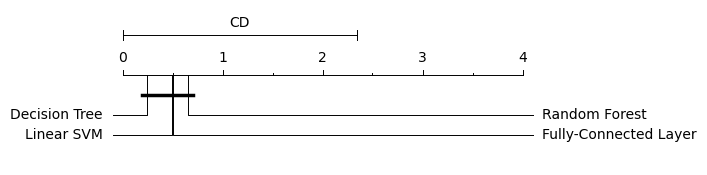

In [8]:
import numpy as np
from Orange.evaluation import compute_CD, graph_ranks
import matplotlib.pyplot as plt

# Generar resultados aleatorios
np.random.seed(42)  # Para reproducibilidad
results = np.random.rand(4, 4)  # 4 datasets, 4 modelos

# Modelos (los nombres deben coincidir con tus métodos)
model_names = ["Linear SVM", "Fully-Connected Layer", "Decision Tree", "Random Forest"]

# Cálculo del CD (Critical Distance)
# `alpha=0.05` es el nivel de significancia para el test de Nemenyi
cd = compute_CD(results, n=len(results))

# Generación del gráfico
graph_ranks(np.mean(results, axis=0), model_names, cd=cd, width=6)

# Guardar la imagen como PNG
plt.savefig("example_critical_distance_diagram.png", dpi=300, bbox_inches="tight")

# Mostrar el gráfico
plt.show()


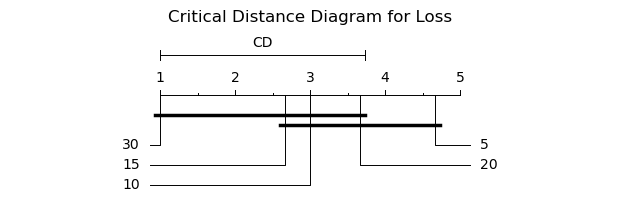

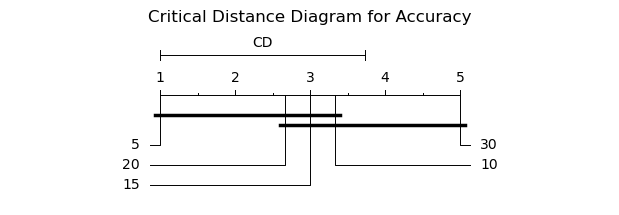

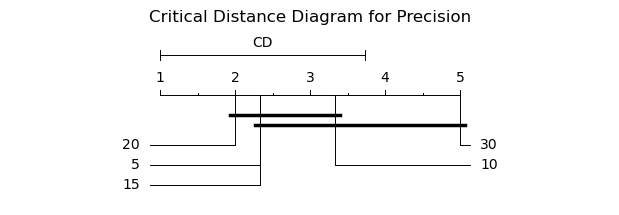

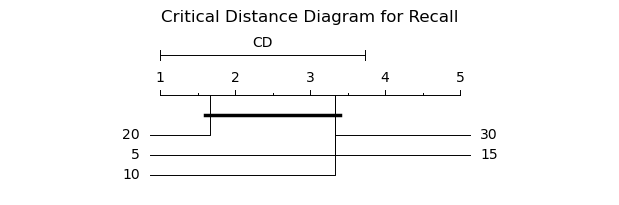

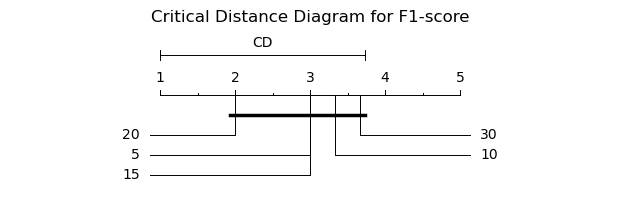

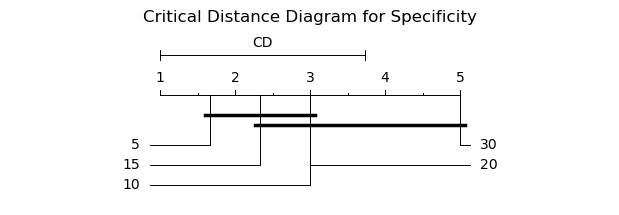

In [13]:
import json
import pandas as pd
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_dunn
import Orange
import matplotlib.pyplot as plt

# Función para cargar y preparar los datos
def parse_experiment_key(key):
    parts = key.split('_')
    architecture = f"{parts[0]}_{parts[1]}"
    splits = int(parts[3])
    epochs = int(parts[5])
    window_size = int(parts[7])
    return architecture, splits, epochs, window_size

def generate_results_table(results):
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity']
    table_data = []

    for key, value in results.items():
        architecture, splits, epochs, window_size = parse_experiment_key(key)
        row = [architecture, splits, epochs, window_size]
        row.extend([value[metric] for metric in metrics])
        table_data.append(row)
    
    columns = ['Architecture', 'Splits', 'Epochs', 'Window Size'] + metrics
    results_df = pd.DataFrame(table_data, columns=columns)
    return results_df

# Función para ejecutar pruebas de Friedman y generar diagramas de distancia crítica
def run_friedman_tests_and_cd_diagrams(results_df):
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity']
    for metric in metrics:
        data = results_df.pivot_table(values=metric, columns='Window Size', index='Architecture', aggfunc='mean')
        rankings = data.rank(axis=1, ascending=False).mean().values
        
        # Diagrama de distancia crítica usando Orange
        cd = Orange.evaluation.compute_CD(rankings, n=len(data.columns))
        Orange.evaluation.graph_ranks(rankings, data.columns, cd=cd, width=6, textspace=1.5)
        plt.title(f'Critical Distance Diagram for {metric}')
        plt.show()

# Cargar resultados del archivo JSON y ejecutar pruebas
json_file = 'experiment_results.json'
if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        results = json.load(f)
        results_df = generate_results_table(results)
        run_friedman_tests_and_cd_diagrams(results_df)
else:
    print("No se encontraron resultados previos.")


In [ ]:
print(results_df.dtypes)
print(results_df.head())


Architecture     object
Splits            int64
Epochs            int64
Window Size       int64
Loss            float64
Accuracy        float64
Precision       float64
Recall          float64
F1-score        float64
Specificity     float64
dtype: object
  Architecture  Splits  Epochs  Window Size      Loss  Accuracy  Precision  \
0       CNN_LF       5      50            5  0.630778  0.645840   0.619152   
1       CNN_LF       5      50           10  0.678752  0.611111   0.586686   
2       CNN_LF       5      50           15  0.697200  0.582288   0.565782   
3       CNN_LF       5      50           20  0.708577  0.564072   0.546897   
4       CNN_LF       5      50           30  0.844950  0.441791   0.417086   

     Recall  F1-score  Specificity  
0  0.675134  0.643486     0.619386  
1  0.781818  0.667773     0.439044  
2  0.781159  0.655693     0.375940  
3  0.847059  0.664312     0.270732  
4  0.859259  0.549945     0.160000  


# Gráficas de resultados por combinacion de variables